In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

import sys
sys.path.insert(0, "../utils")
import bootcampviztools as viz
import ToolBox as tb

from collections import Counter

from scipy.io import arff

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action="ignore")

### **1. Cargar los datos**

In [5]:
data, meta = arff.loadarff("../data_sample/speed_dating.arff") # Cargo directamente por separado los datos en forma de array y los metadatos proporcionados
meta

Dataset: 'Speed
	has_null's type is nominal, range is ('0', '1')
	wave's type is numeric
	gender's type is nominal, range is ('female', 'male')
	age's type is numeric
	age_o's type is numeric
	d_age's type is numeric
	d_d_age's type is nominal, range is ('[4-6]', '[0-1]', '[2-3]', '[7-37]')
	race's type is nominal, range is ('Asian/Pacific Islander/Asian-American', 'European/Caucasian-American', 'Other', 'Latino/Hispanic American', 'Black/African American')
	race_o's type is nominal, range is ('European/Caucasian-American', 'Asian/Pacific Islander/Asian-American', 'Latino/Hispanic American', 'Other', 'Black/African American')
	samerace's type is nominal, range is ('0', '1')
	importance_same_race's type is numeric
	importance_same_religion's type is numeric
	d_importance_same_race's type is nominal, range is ('[2-5]', '[6-10]', '[0-1]')
	d_importance_same_religion's type is nominal, range is ('[2-5]', '[0-1]', '[6-10]')
	field's type is nominal, range is ('Law', 'law', 'Economics', 'Mas

In [6]:
data

array([(b'0',  1., b'female', 21., 27., 6., b'[4-6]', b'Asian/Pacific Islander/Asian-American', b'European/Caucasian-American', b'0', 2., 4., b'[2-5]', b'[2-5]', b'Law', 35., 20., 20., 20.,  0.,  5., b'[21-100]', b'[16-20]', b'[16-20]', b'[16-20]', b'[0-15]', b'[0-15]',  6.,  8.,  8.,  8.,  8.,  6., b'[6-8]', b'[6-8]', b'[6-8]', b'[6-8]', b'[6-8]', b'[6-8]', 15., 20., 20., 15., 15., 15., b'[0-15]', b'[16-20]', b'[16-20]', b'[0-15]', b'[0-15]', b'[0-15]', 6., 8., 8., 8., 7., b'[6-8]', b'[6-8]', b'[6-8]', b'[6-8]', b'[6-8]', 6., 9., 7., 7.,  6.,  5., b'[6-8]', b'[9-10]', b'[6-8]', b'[6-8]', b'[6-8]', b'[0-5]', 9., 2., 8.,  9.,  1.,  1., 5., 1., 5., 6., 9., 1., 10., 10.,  9., 8., 1., b'[9-10]', b'[0-5]', b'[6-8]', b'[9-10]', b'[0-5]', b'[0-5]', b'[0-5]', b'[0-5]', b'[0-5]', b'[6-8]', b'[9-10]', b'[0-5]', b'[9-10]', b'[9-10]', b'[9-10]', b'[6-8]', b'[0-5]',  0.14, b'[0-0.33]',  3.,  2., 4., b'[0-4]', b'[0-3]', b'[3-5]', 7.,  6., b'[6-8]', b'[5-6]', 0., b'1', b'0', b'0'),
       (b'0',  1.,

In [7]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
df = pd.DataFrame(data)
df

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'0',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',35.0,20.0,20.0,20.0,0.0,5.0,b'[21-100]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,8.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',6.0,9.0,7.0,7.0,6.0,5.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.14,b'[0-0.33]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'0',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',60.0,0.0,0.0,40.0,0.0,0.0,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,8.0,10.0,7.0,7.0,5.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[0-5]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0,8.0,7.0,8.0,5.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.54,b'[0.33-1]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'1',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',19.0,18.0,19.0,18.0,14.0,12.0,b'[16-20]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',10.0,10.0,10.0,10.0,10.0,10.0,b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8

Todas las variables que originalmente son de tipo "object", infiere que son de tipo "bytes".

### **3. Train, test**

In [8]:
target = "match" # Todavía no voy a separar X e y, pero me guardo el target en una variable

In [9]:
train, test = train_test_split(df, test_size= 0.2, random_state=42)

In [10]:
sets_names = ["Train", "Test"]
sets = [train, test]

In [11]:
for set, set_name in zip(sets, sets_names):
    print(f"Dimensiones de {set_name}: {set.shape}")

Dimensiones de Train: (6702, 123)
Dimensiones de Test: (1676, 123)


### **4. Target**

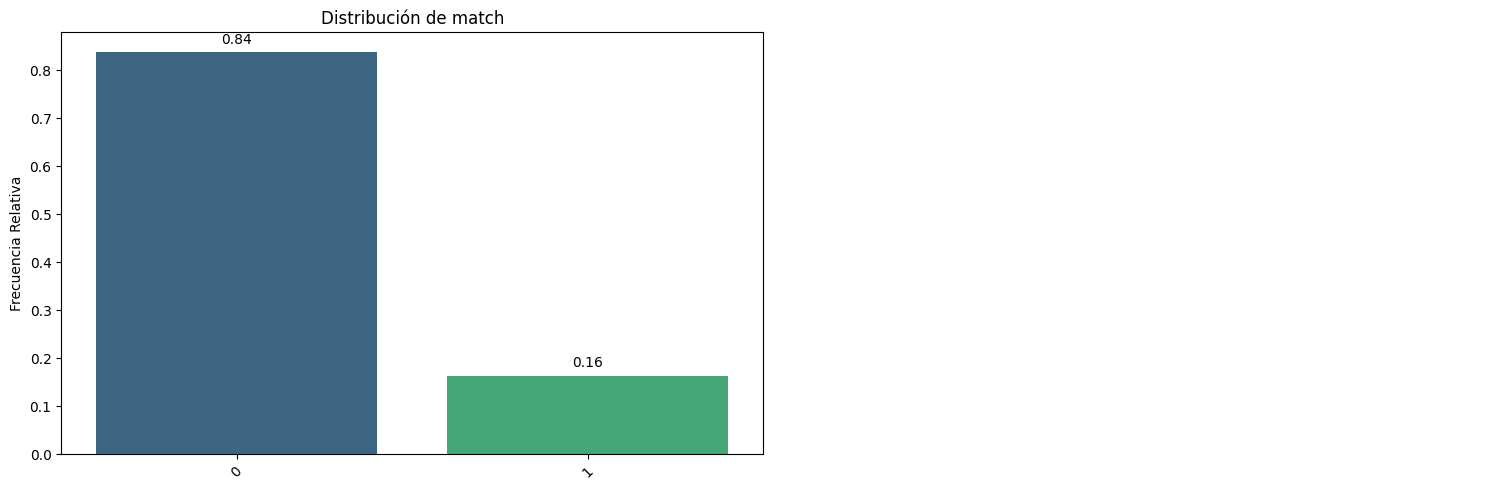

In [12]:
viz.pinta_distribucion_categoricas(train, [target], mostrar_valores=True, relativa=True)

Muy desbalanceado, probaré con las métricas adecuadas para tenerlos en cuenta, el argumento *class_weight* y una reducción de muestras, quizá para que quede un 66 - 34% en vez de un target tan desbalanceado. Me quedaré con la técnica o combinación de técnicas que mejor funcione.

### **5. Entender las variables**

Para hacerme una idea general utilizaré los metadatos y la descripción de ciertas variables concretas.

In [13]:
meta

Dataset: 'Speed
	has_null's type is nominal, range is ('0', '1')
	wave's type is numeric
	gender's type is nominal, range is ('female', 'male')
	age's type is numeric
	age_o's type is numeric
	d_age's type is numeric
	d_d_age's type is nominal, range is ('[4-6]', '[0-1]', '[2-3]', '[7-37]')
	race's type is nominal, range is ('Asian/Pacific Islander/Asian-American', 'European/Caucasian-American', 'Other', 'Latino/Hispanic American', 'Black/African American')
	race_o's type is nominal, range is ('European/Caucasian-American', 'Asian/Pacific Islander/Asian-American', 'Latino/Hispanic American', 'Other', 'Black/African American')
	samerace's type is nominal, range is ('0', '1')
	importance_same_race's type is numeric
	importance_same_religion's type is numeric
	d_importance_same_race's type is nominal, range is ('[2-5]', '[6-10]', '[0-1]')
	d_importance_same_religion's type is nominal, range is ('[2-5]', '[0-1]', '[6-10]')
	field's type is nominal, range is ('Law', 'law', 'Economics', 'Mas

*Se ve que hay bastantes variables binarias, parece que hay algunas continuas y discretas y algunas otras categóricas y categóricas creadas a partir de numéricas.*

In [14]:
with open("../data_sample/feature_information.txt", "r") as open_file:
    all_text = open_file.read()
    print(all_text)

 * gender: Gender of self  
 * age: Age of self  
 * age_o: Age of partner  
 * d_age: Difference in age  
 * race: Race of self  
 * race_o: Race of partner  
 * samerace: Whether the two persons have the same race or not.  
 * importance_same_race: How important is it that partner is of same race?  
 * importance_same_religion: How important is it that partner has same religion?  
 * field: Field of study  
 * pref_o_attractive: How important does partner rate attractiveness  
 * pref_o_sinsere: How important does partner rate sincerity  
 * pref_o_intelligence: How important does partner rate intelligence  
 * pref_o_funny: How important does partner rate being funny  
 * pref_o_ambitious: How important does partner rate ambition  
 * pref_o_shared_interests: How important does partner rate having shared interests  
 * attractive_o: Rating by partner (about me) at night of event on attractiveness  
 * sincere_o: Rating by partner (about me) at night of event on sincerity  
 * intell

Las variables que tienen "\_o" hacen referencia a la otra persona, las que tienen "d\_" y tienen un rango de valores (no un solo valor numérico) a la variable categórica creada a partir de la numérica con el mismo nombre quitando la "d\_". Además hay variables que tenemos que descartar porque no las vamos a conocer cuando hagamos las predicciones de las citas que no se han producido todavía.

In [15]:
for ds in [train, test]:
    ds.rename(columns= {"d_age": "dif_age", "d_d_age": "d_dif_age"}, inplace=True)

Lo primero que voy a hacer es ir viendo las variables una a una e ir descartando de las que no podamos disponer antes de que se realicen las citas.

In [16]:
train.head(3)

,has_null,wave,gender,age,age_o,dif_age,d_dif_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
5677,b'1',14.0,b'male',27.0,22.0,5.0,b'[4-6]',b'European/Caucasian-American',b'European/Caucasian-American',b'1',3.0,2.0,b'[2-5]',b'[2-5]',b'MBA',20.0,10.0,20.0,20.0,20.0,10.0,b'[16-20]',b'[0-15]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',7.0,10.0,6.0,6.0,6.0,3.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',30.0,20.0,15.0,15.0,8.0,12.0,b'[21-100]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',b'[0-15]',8.0,9.0,9.0,8.0,9.0,b'[6-8]',b'[9-10]',b'[9-10]',b'[6-8]',b'[9-10]',2.0,3.0,6.0,4.0,6.0,3.0,b'[0-5]',b'[0-5]',b'[6-8]',b'[0-5]',b'[6-8]',b'[0-5]',9.0,8.0,5.0,8.0,4.0,4.0,2.0,2.0,7.0,5.0,6.0,5.0,6.0,3.0,6.0,7.0,3.0,b'[9-10]',b'[6-8]',b'[0-5]',b'[6-8]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[0-5]',b'[6-8]',b'[0-5]',b'[6-8]',b'[0-5]',b'[6-8]',b'[6-8]',b'[0-5]',0.49,b'[0.33-1]',5.0,NaN,6.0,b'[5-6]',b'[0-3]',b'[5-18]',4.0,4.0,b'[0-5]',b'[0-4]',0.0,b'0',b'1',b'0'
664,b'0',2.0,b'male',22.0,22.0,0.0,b'[0-1]',b'European/Caucasian-American',b'European/Caucasian-American',b'1',9.0,2.0,b'[6-10]',b'[2-5]',b'Undergrad - GS',20.0,22.0,18.0,15.0,15.0,10.0,b'[16-20]',b'[21-100]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',8.0,7.0,8.0,8.0,8.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',30.0,15.0,25.0,25.0,5.0,0.0,b'[21-100]',b'[0-15]',b'[21-100]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,9.0,6.0,7.0,6.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',6.0,8.0,9.0,5.0,9.0,3.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[0-5]',3.0,1.0,6.0,7.0,7.0,8.0,1.0,5.0,8.0,4.0,6.0,10.0,10.0,6.0,8.0,6.0,2.0,b'[0-5]',b'[0-5]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[0-5]',b'[6-8]',b'[0-5]',b'[6-8]',b'[9-10]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',0.11,b'[0-0.33]',6.0,5.0,2.0,b'[5-6]',b'[4-9]',b'[0-2]',5.0,7.0,b'[0-5]',b'[7-10]',0.0,b'0',b'1',b'0'
4366,b'1',11.0,b'male',28.0,23.0,5.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',1.0,2.0,b'[0-1]',b'[2-5]',b'MBA / Master of International Affairs [SIPA]',10.0,15.0,40.0,15.0,10.0,10.0,b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',b'[0-15]',4.0,7.0,7.0,7.0,5.0,6.0,b'[0-5]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',20.0,30.0,10.0,20.0,0.0,20.0,b'[16-20]',b'[21-100]',b'[0-15]',b'[16-20]',b'[0-15]',b'[16-20]',4.0,9.0,10.0,8.0,8.0,b'[0-5]',b

In [17]:
train.d_dif_age.unique()

array([b'[4-6]', b'[0-1]', b'[2-3]', b'[7-37]'], dtype=object)

In [18]:
print(train.columns.to_list())

['has_null', 'wave', 'gender', 'age', 'age_o', 'dif_age', 'd_dif_age', 'race', 'race_o', 'samerace', 'importance_same_race', 'importance_same_religion', 'd_importance_same_race', 'd_importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'attractive', 'sincere

In [19]:
columns_to_exclude = ['attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'like', 'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision', 'decision_o']

#### Algunas ideas para transformaciones de features: ratio entre lo atractivo, inteligente, etc. que una persona se percibe y lo que le importa esa cualidad. Relación entre lo atractiva que se percibe una persona y lo atractiva que se percibe la otra (probablemente diferencia, pero también podría ser ratio). Otra nueva feature: ver si correlan las importancias que le dan a los atributos de la otra persona.

Voy a crear un transformador que pueda incluir en mi pipeline para excluir estas columnas.

In [20]:
train_bck = train.copy()
test_bck = test.copy()

In [21]:
pipe_exclude_columns = ColumnTransformer([("exclude", "drop", columns_to_exclude)], remainder= "passthrough")

In [22]:
train_compact = pipe_exclude_columns.fit_transform(train)
test_compact = pipe_exclude_columns.transform(test)

In [23]:
sets_names_2 = ["Train", "Test"]
sets_2 = [train_compact, test_compact]

In [24]:
for ds, ds_name in zip(sets_2, sets_names_2):
    print(f"Dimensiones actuales de {ds_name}: {ds.shape}")

Dimensiones actuales de Train: (6702, 92)
Dimensiones actuales de Test: (1676, 92)


In [25]:
train = train.drop(columns= columns_to_exclude).copy()

Ya quedan solo los conjuntos con las variables deseadas más el target.

In [26]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
wave,6702.0,11.365712,5.974235,1.00,7.00,11.000,15.00,21.00
age,6627.0,26.343745,3.586012,18.00,24.00,26.000,28.00,55.00
age_o,6618.0,26.355243,3.562432,18.00,24.00,26.000,28.00,55.00
dif_age,6702.0,4.188750,4.605983,0.00,1.00,3.000,5.00,37.00
importance_same_race,6643.0,3.790908,2.845531,0.00,1.00,3.000,6.00,10.00
importance_same_religion,6643.0,3.645793,2.804681,1.00,1.00,3.000,6.00,10.00
pref_o_attractive,6633.0,22.484852,12.499627,0.00,15.00,20.000,25.00,100.00
pref_o_sincere,6633.0,17.407114,6.974170,0.00,15.00,18.370,20.00,60.00
pref_o_intelligence,6633.0,20.265414,6.803352,0.00,17.39,20.000,23.26,50.00
pref_o_funny,6625.0,17.465381,6.075512,0.00,15.00,18.000,20.00,50.00


Hay algunos valores raros, como mínimos de 0 en algunas de las features que recogen la importancia de los atributos de la otra personas, no parece muy normal que se le de una importancia de 0 a un atributo de una posible pareja, pero a su vez son variables con valores faltantes, por lo que no parece que haya sido una imputación, vamos a ver las frecuencias de algunas de estas variables.

In [27]:
train.pref_o_ambitious[train.pref_o_ambitious>15].value_counts(dropna=False).sum()

np.int64(1348)

In [28]:
train.pref_o_ambitious[train.pref_o_ambitious<=15].value_counts().sum()

np.int64(5269)

In [29]:
train.pref_o_ambitious.value_counts(dropna=False).sum()

np.int64(6702)

In [30]:
train.d_pref_o_ambitious.value_counts(dropna=False)

d_pref_o_ambitious
b'[0-15]'      5354
b'[16-20]'     1269
b'[21-100]'      79
Name: count, dtype: int64

In [31]:
dict_0_nan = {"0_num": [], "0_cat": [], "missings_num": [], "missings_cat": [], "0-15_num": [], "0-15_cat": [], "16+_num": [], "16+_cat": []}
for col in train.loc[:,[col.__contains__("pref_o") for col in train]]:
    try: 
        dict_0_nan["0_num"].append(train[col].value_counts()[0.00])
        dict_0_nan["missings_num"].append(train[col].value_counts(dropna = False)[np.nan])
        dict_0_nan["0-15_num"].append(train[col][train[col]<=15].value_counts().sum())
        dict_0_nan["16+_num"].append(train[col][train[col]>15].value_counts().sum())
    except:
        dict_0_nan["0_cat"].append(0)
        dict_0_nan["missings_cat"].append(0)
        dict_0_nan["0-15_cat"].append(train[col][train[col]== "[0-15]"].value_counts().sum())
        dict_0_nan["16+_cat"].append(train[col][train[col]!= "[0-15]"].value_counts().sum())


df_0_nan = pd.DataFrame(dict_0_nan, index= train.loc[:,[col.startswith("pref_o") for col in train]].columns)

In [32]:
df_0_nan

,0_num,0_cat,missings_num,missings_cat,0-15_num,0-15_cat,16+_num,16+_cat
pref_o_attractive,19,0,69,0,1901,0,4732,6702
pref_o_sincere,155,0,69,0,2380,0,4253,6702
pref_o_intelligence,63,0,69,0,1214,0,5419,6702
pref_o_funny,24,0,77,0,2491,0,4134,6702
pref_o_ambitious,648,0,85,0,5269,0,1348,6702
pref_o_shared_interests,572,0,102,0,4801,0,1799,6702


Este análisis me parece más relevante en la parte de los nulos.

#### Forzando los tipos

In [33]:
train.dtypes

has_null                            object
wave                               float64
gender                              object
age                                float64
age_o                              float64
                                    ...   
expected_num_matches               float64
d_expected_happy_with_sd_people     object
d_expected_num_interested_in_me     object
d_expected_num_matches              object
match                               object
Length: 92, dtype: object

In [34]:
train.has_null.astype(int)

5677    1
664     0
4366    1
5688    1
208     0
       ..
5734    1
5191    1
5390    1
860     0
7270    1
Name: has_null, Length: 6702, dtype: int64

In [35]:
train.dtypes.value_counts()

object     48
float64    44
Name: count, dtype: int64

In [36]:
for ds in [train, train_bck, test]: # Los fuerzo ya en todos los conjuntos (train_bck) es el conjunto con todas las variables que luego voy a pasar por el pipeline
    for col in ds:
        if ds[col].dtype == object:
            try:
                ds[col] = ds[col].astype(int) # Si es posible convertirla a entero, se convierte a entero, si no a string
            except:
                ds[col] = ds[col].astype(str)

In [37]:
for col in train:
    if train[col].dtype == object:
        try:
            train[col] = train[col].astype(int)
        except:
            train[col] = train[col].astype(str)

In [38]:
train.dtypes.value_counts()

object     45
float64    44
int64       3
Name: count, dtype: int64

In [39]:
train.loc[:, [col for col in train.columns if train[col].dtype == object]]

,gender,d_dif_age,race,race_o,d_importance_same_race,d_importance_same_religion,field,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches
5677,male,[4-6],European/Caucasian-American,European/Caucasian-American,[2-5],[2-5],MBA,[16-20],[0-15],[16-20],[16-20],[16-20],[0-15],[21-100],[16-20],[0-15],[0-15],[0-15],[0-15],[6-8],[9-10],[9-10],[6-8],[9-10],[9-10],[6-8],[0-5],[6-8],[0-5],[0-5],[0-5],[0-5],[6-8],[0-5],[6-8],[0-5],[6-8],[0-5],[6-8],[6-8],[0-5],[0.33-1],[5-6],[0-3],[5-18]
664,male,[0-1],European/Caucasian-American,European/Caucasian-American,[6-10],[2-5],Undergrad - GS,[16-20],[21-100],[16-20],[0-15],[0-15],[0-15],[21-100],[0-15],[21-100],[21-100],[0-15],[0-15],[6-8],[9-10],[6-8],[6-8],[6-8],[0-5],[0-5],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],[6-8],[0-5],[6-8],[9-10],[9-10],[6-8],[6-8],[6-8],[0-5],[0-0.33],[5-6],[4-9],[0-2]
4366,male,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[0-1],[2-5],MBA / Master of International Affairs [SIPA],[0-15],[0-15],[21-100],[0-15],[0-15],[0-15],[16-20],[21-100],[0-15],[16-20],[0-15],[16-20],[0-5],[9-10],[9-10],[6-8],[6-8],[9-10],[6-8],[0-5],[6-8],[0-5],[6-8],[9-10],[0-5],[0-5],[9-10],[6-8],[0-5],[6-8],[6-8],[6-8],[0-5],[0-5],[-1-0],[7-10],[0-3],[0-2]
5688,male,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[6-10],[6-10],business,[0-15],[16-20],[21-100],[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],[16-20],[0-15],[0-15],[6-8],[9-10],[6-8],[9-10],[9-10],[0-5],[0-5],[0-5],[9-10],[0-5],[6-8],[6-8],[6-8],[0-5],[0-5],[9-10],[6-8],[9-10],[0-5],[6-8],[9-10],[0-5],[0-0.33],[5-6],[0-3],[0-2]
208,female,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[6-10],[6-10],Operations Research,[21-100],[0-15],[21-100],[21-100],[0-15],[0-15],[0-15],[16-20],[16-20],[16-20],[16-20],[16-20],[0-5],[9-10],[6-8],[9-10],[9-10],[9-10],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[6-8],[0-5],[6-8],[0-5],[0-5],[-1-0],[5-6],[0-3],[0-2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,male,[4-6],European/Caucasian-American,Asian/Pacific Islander/Asian-American,[2-5],[2-5],MBA,[0-15],[0-15],[21-100],[0-15],[0-15],[0-15],[21-100],[0-15],[16-20],[16-20],[0-15],[0-15],[6-8],[6-8],[6-8],[9-10],[6-8],[9-10],[0-5],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[6-8],[0-5],[0-5],[6-8],[0-5],[6-8],[0-5],[0-5],[0-0.33],[5-6],[0-3],[3-5]
5191,female,[4-6],European/Caucasian-American,European/Caucasian-American,[6-10],[2-5],Applied Physiology & Nutrition,[0-15],[16-20],[16-20],[16-20],[0-15],[16-20],[0-15],[21-100],[21-100],[0-15],[0-15],[0-15],[6-8],[9-10],[6-8],[6-8],[6-8],[9-10],[0-5],[9-10],[9-10],[6-8],[6-8],[6-8],[6-8],[6-8],[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],[0-5],[6-8],[0-0.33],[5-6],[0-3],[0-2]
5390,male,[7-37],European/Caucasian-American,Black/African American,[2-5],[2-5],Intellectual Property Law,[21-100],[0-15],[0-15],[16-20],[21-100],[0-15],[21-100],[16-20],[21-100],[0-15],[0-15],[0-15],[6-8],[6-8],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[9-10],[9-10],[0-5],[0-5],[0-5],[9-10],[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],[0-5],[0-0.33],[5-6],[0-3],[3-5]
860,female,[0-1],European/Caucasian-American,Black/African American,[0-1],[2-5],German Literature,[21-100],[16-20],[21-100],[16-20],[0-15],[0-15],[0-15],[0-15],[16-20],[0-15],[0-15],[16-20],[6-8],[9-10],[6-8],[9-10],[6-8],[0-5],[0

In [40]:
train.loc[:, [col for col in train.columns if train[col].dtype == float]]

,wave,age,age_o,dif_age,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches
5677,14.0,27.0,22.0,5.0,3.0,2.0,20.0,10.0,20.0,20.0,20.0,10.0,30.0,20.0,15.0,15.0,8.0,12.0,8.0,9.0,9.0,8.0,9.0,9.0,8.0,5.0,8.0,4.0,4.0,2.0,2.0,7.0,5.0,6.0,5.0,6.0,3.0,6.0,7.0,3.0,0.49,5.0,NaN,6.0
664,2.0,22.0,22.0,0.0,9.0,2.0,20.0,22.0,18.0,15.0,15.0,10.0,30.0,15.0,25.0,25.0,5.0,0.0,7.0,9.0,6.0,7.0,6.0,3.0,1.0,6.0,7.0,7.0,8.0,1.0,5.0,8.0,4.0,6.0,10.0,10.0,6.0,8.0,6.0,2.0,0.11,6.0,5.0,2.0
4366,11.0,28.0,23.0,5.0,1.0,2.0,10.0,15.0,40.0,15.0,10.0,10.0,20.0,30.0,10.0,20.0,0.0,20.0,4.0,9.0,10.0,8.0,8.0,10.0,6.0,1.0,7.0,3.0,6.0,10.0,5.0,3.0,10.0,6.0,5.0,7.0,6.0,8.0,2.0,1.0,-0.37,7.0,NaN,2.0
5688,14.0,25.0,24.0,1.0,10.0,7.0,10.0,20.0,27.0,23.0,15.0,5.0,30.0,10.0,15.0,20.0,15.0,10.0,6.0,10.0,8.0,9.0,10.0,4.0,1.0,4.0,10.0,5.0,6.0,7.0,7.0,3.0,3.0,9.0,7.0,9.0,5.0,6.0,9.0,5.0,0.02,5.0,NaN,1.0
208,2.0,21.0,22.0,1.0,8.0,10.0,30.0,15.0,25.0,25.0,5.0,0.0,12.0,18.0,20.0,16.0,16.0,18.0,5.0,9.0,7.0,9.0,10.0,10.0,8.0,10.0,5.0,5.0,5.0,2.0,1.0,3.0,7.0,10.0,4.0,7.0,4.0,8.0,5.0,2.0,-0.08,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,14.0,29.0,35.0,6.0,3.0,2.0,15.0,15.0,30.0,15.0,15.0,10.0,25.0,15.0,20.0,20.0,10.0,10.0,6.0,7.0,7.0,9.0,7.0,9.0,5.0,10.0,5.0,4.0,4.0,2.0,1.0,8.0,7.0,3.0,3.0,8.0,5.0,8.0,5.0,2.0,0.08,6.0,NaN,3.0
5191,14.0,31.0,27.0,4.0,9.0,5.0,14.0,18.0,17.0,16.0,15.0,20.0,12.0,25.0,25.0,8.0,15.0,15.0,7.0,10.0,6.0,8.0,8.0,9.0,2.0,10.0,9.0,8.0,8.0,8.0,7.0,7.0,9.0,9.0,9.0,9.0,9.0,9.0,5.0,7.0,0.02,6.0,NaN,2.0
5390,14.0,34.0,26.0,8.0,5.0,5.0,30.0,5.0,10.0,20.0,30.0,5.0,30.0,20.0,30.0,5.0,5.0,10.0,7.0,7.0,5.0,7.0,9.0,3.0,1.0,3.0,5.0,9.0,10.0,3.0,3.0,4.0,10.0,6.0,8.0,9.0,7.0,7.0,3.0,2.0,0.08,5.0,NaN,4.0
860,3.0,28.0,27.0,1.0,1.0,5.0,21.0,17.0,22.0,20.0,8.0,13.0,15.0,15.0,20.0,15.0,15.0,20.0,7.0,10.0,7.0,10.0,7.0,1.0,1.0,5.0,10.0,10.0,10.0,5.0,1.0,5.0,10.0,6.0,10.0,10.0,8.0,10.0,8.0,7.0,0.80,5.0,5.0,1.0


In [41]:
train.sincere.value_counts()

sincere
9.0     1934
8.0     1767
10.0    1359
7.0      928
6.0      389
5.0      121
4.0       74
2.0       28
3.0       21
Name: count, dtype: int64

### **6. Reducción preliminar de features**

Porcentaje de nulos

In [42]:
report = tb.describe_df(train).T
report.loc[report["MISSINGS (%)"]> 0.2]

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
expected_num_interested_in_me,float64,0.787974,18,0.002686


Voy a probar a ver si es informativo con respecto al target pasar la columna a categórica en función de si está informada o no. Si me deshago de ella me tendré que deshacer también de su equivalente en categórica, ya que realmente se habría creado una variable nueva a partir de otra demasiado desinformada.

In [43]:
train["interested_in_me_cat"] = train.expected_num_interested_in_me.fillna("UNK")
train.interested_in_me_cat = (train.interested_in_me_cat != "UNK").astype(int)

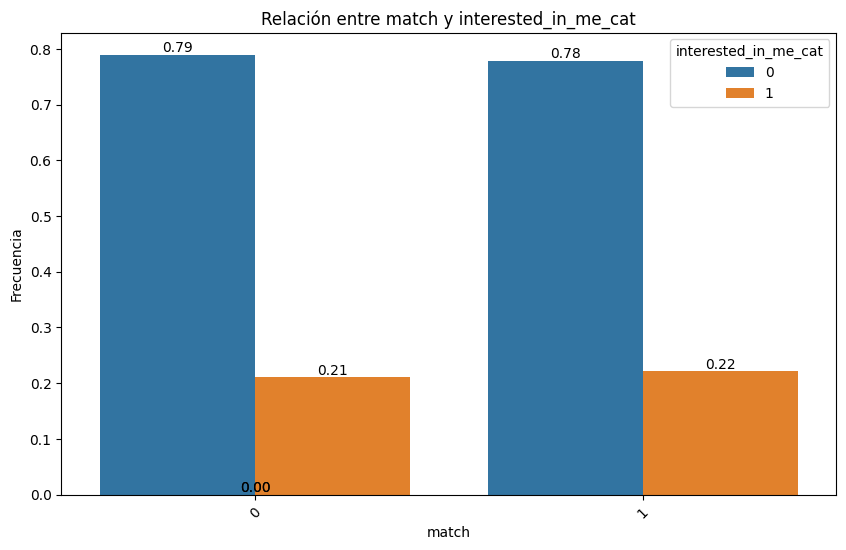

In [44]:
viz.plot_categorical_relationship_fin(train, target, "interested_in_me_cat", relative_freq=True, show_values=True)

No parece que sea nada informativa del target, voy a comprobar con el coeficiente de información mutua.

In [45]:
mutual_info_score(train[target], train.interested_in_me_cat)

np.float64(5.09058207535662e-05)

Efectivamente, esto me confirma que contiene muy poca información del target, ya que el valor es muy cercano a 0.

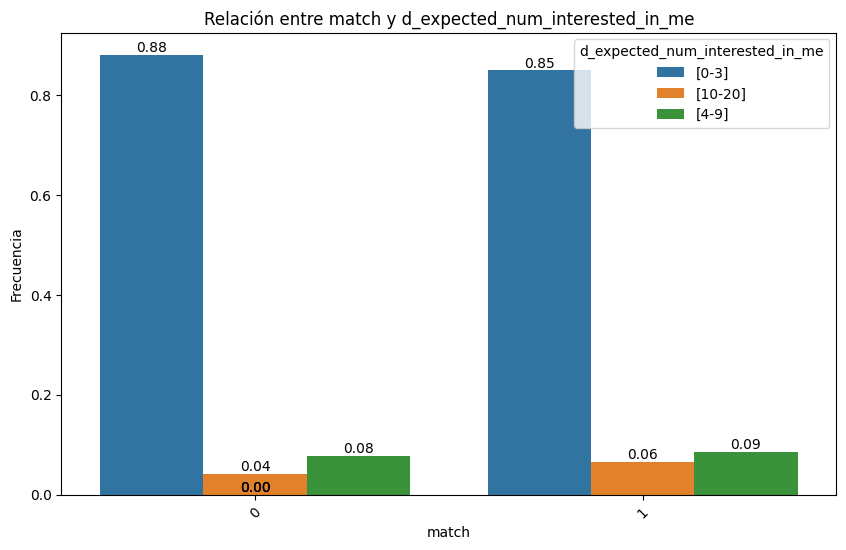

In [46]:
viz.plot_categorical_relationship_fin(train, target, "d_expected_num_interested_in_me", relative_freq=True, show_values=True)

No parece que sea nada informativa del target, voy a comprobar con el coeficiente de información mutua.

In [47]:
mutual_info_score(train[target], train.d_expected_num_interested_in_me)

np.float64(0.0008907372373465061)

Valor muy cercano a 0 también. Elimino las dos:

In [48]:
for col in train:
    if col.__contains__("interested_in_me"):
        train.drop(columns = col, inplace= True)
        columns_to_exclude.append(col)
print(train.shape)

(6702, 90)


Voy a eliminar "has_null" porque no aporta nada.

In [49]:
train.drop(columns= "has_null", inplace=True)
columns_to_exclude.append("has_null")


#### **Selección de features**

Tres selectores que utilizan feature importance de modelos: RFE, RFECV y SelectFromModel, todos utilizando random forest

In [50]:
p_features = train.drop(columns=[target, "field"]).columns.to_list()
X_train = train[p_features].copy()
y_train = train[target]

In [51]:
cat_vars = [col for col in p_features if train[col].dtype == object]
num_vars = [col for col in p_features if col not in cat_vars]

In [52]:
print(len(cat_vars), len(num_vars))

43 44


In [53]:
for col in cat_vars:
    print(col, ":", train[col].unique())

gender : ['male' 'female']
d_dif_age : ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
race : ['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Black/African American' 'Other' 'Latino/Hispanic American' '?']
race_o : ['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Other' 'Latino/Hispanic American' 'Black/African American' '?']
d_importance_same_race : ['[2-5]' '[6-10]' '[0-1]']
d_importance_same_religion : ['[2-5]' '[6-10]' '[0-1]']
d_pref_o_attractive : ['[16-20]' '[0-15]' '[21-100]']
d_pref_o_sincere : ['[0-15]' '[21-100]' '[16-20]']
d_pref_o_intelligence : ['[16-20]' '[21-100]' '[0-15]']
d_pref_o_funny : ['[16-20]' '[0-15]' '[21-100]']
d_pref_o_ambitious : ['[16-20]' '[0-15]' '[21-100]']
d_pref_o_shared_interests : ['[0-15]' '[16-20]' '[21-100]']
d_attractive_important : ['[21-100]' '[16-20]' '[0-15]']
d_sincere_important : ['[16-20]' '[0-15]' '[21-100]']
d_intellicence_important : ['[0-15]' '[21-100]' '[16-20]']
d_funny_important : ['[0-15]' '[21-

In [54]:
[col for col in cat_vars if col.__contains__("race")]

['race', 'race_o', 'd_importance_same_race']

In [55]:
o_encoder =OrdinalEncoder(categories = [["[0-15]", "[16-20]", "[21-100]"]])
o_encoder.fit_transform(X_train[["d_pref_o_ambitious"]])

array([[1.],
       [0.],
       [0.],
       ...,
       [2.],
       [0.],
       [0.]], shape=(6702, 1))

In [56]:
o_encoder.categories

[['[0-15]', '[16-20]', '[21-100]']]

In [57]:
[["[0-15]", "[16-20]", "[21-100]"]] * 2

[['[0-15]', '[16-20]', '[21-100]'], ['[0-15]', '[16-20]', '[21-100]']]

In [58]:
[col for col in p_features if "[0-15]" in train[col].unique()]

['d_pref_o_attractive',
 'd_pref_o_sincere',
 'd_pref_o_intelligence',
 'd_pref_o_funny',
 'd_pref_o_ambitious',
 'd_pref_o_shared_interests',
 'd_attractive_important',
 'd_sincere_important',
 'd_intellicence_important',
 'd_funny_important',
 'd_ambtition_important',
 'd_shared_interests_important']

In [59]:
list_100 = [col for col in p_features if "[0-15]" in train[col].unique()]
list_10 = [col for col in p_features if "[0-5]" in train[col].unique()]
list_10_2 = [col for col in p_features if "[2-5]" in train[col].unique()]
list_happy = ["d_expected_happy_with_sd_people"]
list_dif_age = ["d_dif_age"]
list_int_correlation = ["d_interests_correlate"]
list_exp_num_matches = ["d_expected_num_matches"]
list_gender = ["gender"]
cat_vars_pipeline = list_100 + list_10 + list_10_2 + list_happy + list_dif_age + list_int_correlation + list_exp_num_matches + list_gender

In [60]:
oh_categories = ['European/Caucasian-American', 'Asian/Pacific Islander/Asian-American',
 'Latino/Hispanic American', 'Other', 'Black/African American', '?']
oh_vars = []
for col in ["race", "race_o"]:
    for suf in oh_categories:
        oh_vars.append(f"{col}_{suf}")

In [61]:
[oh_categories] * 2

[['European/Caucasian-American',
  'Asian/Pacific Islander/Asian-American',
  'Latino/Hispanic American',
  'Other',
  'Black/African American',
  '?'],
 ['European/Caucasian-American',
  'Asian/Pacific Islander/Asian-American',
  'Latino/Hispanic American',
  'Other',
  'Black/African American',
  '?']]

In [62]:
preprocessing = ColumnTransformer(
    [("Categorical_Encoder_100", OrdinalEncoder(categories = [["[0-15]", "[16-20]", "[21-100]"]] * len(list_100) + [["[0-5]", "[6-8]", "[9-10]"]] * len(list_10) + [["[0-1]", "[2-5]", "[6-10]"]] * len(list_10_2) + [["[0-4]", "[5-6]", "[7-10]"]] + [["[0-1]", "[2-3]", "[4-6]", "[7-37]"]] + [["[-1-0]", "[0-0.33]", "[0.33-1]"]] + [["[0-2]", "[3-5]", "[5-18]"]] + [["male", "female"]]), cat_vars_pipeline),
     ("Categorical_Encoder_race", OneHotEncoder(categories=[oh_categories] * 2), ["race", "race_o"])],
     remainder= "passthrough"
)

preprocessing.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorical_Encoder_100',
                                 OrdinalEncoder(categories=[['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-20]',
                                                             '[21-100]'],
                                                            ['[0-15]',
                                                             '[16-2...
                                ('Categorical_Encoder_race',
                                 OneHotEncoder(categories=[['European/Caucasian-American',
                                                            'Asian/Pacific '
                                                            'Islander/Asian-American',
                                                            'Latino/Hispanic '
                                                            'American',
                                                            'Other',
                                                            'Black/African '
                                                            'American',
                                                            '?'],
                                                           ['European/Caucasian-American',
                                                            'Asian/Pacific '
                                                            'Islander/Asian-American',
                                                            'Latino/Hispanic '
                                                            'American',
                                                            'Other',
                                                            'Black/African '
                                                            'American',
                                                            '?']]),
                                 ['race', 'race_o'])])

In [63]:
X_train_processed_features = cat_vars_pipeline + oh_vars + num_vars

In [64]:
X_train_processed = pd.DataFrame(preprocessing.transform(X_train), columns= X_train_processed_features, index=X_train.index)
tb.describe_df(X_train_processed)

,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,d_importance_same_race,d_importance_same_religion,d_expected_happy_with_sd_people,d_dif_age,d_interests_correlate,d_expected_num_matches,gender,race_European/Caucasian-American,race_Asian/Pacific Islander/Asian-American,race_Latino/Hispanic American,race_Other,race_Black/African American,race_?,race_o_European/Caucasian-American,race_o_Asian/Pacific Islander/Asian-American,race_o_Latino/Hispanic American,race_o_Other,race_o_Black/African American,race_o_?,wave,age,age_o,dif_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches
DATA_TYPE,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011191,0.012534,0.0,0.0,0.008803,0.008803,0.010295,0.010295,0.010295,0.011489,0.012683,0.015219,0.008803,0.008803,0.008803,0.009997,0.011191,0.013429,0.012086,0.012086,0.012086,0.012086,0.012086,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.008803,0.018054,0.011489,0.140107
UNIQUE_VALUES,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,21,24,24,35,2,11,10,94,78,65,71,82,85,94,78,65,71,82,85,9,9,9,8,9,10,10,10,10,11,11,11,12,11,11,10,11,10,11,10,10,11,154,10,17
CARDIN (%),0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000597,0.000448,0.000448,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.003133,0.003581,0.003581,0.005222,0.000298,0.001641,0.001492,0.014026,0.011638,0.009699,0.010594,0.012235,0.012683,0.014026,0.011638,0.009699,0.010594,0.012235,0.012683,0.001343,0.001343,0.001343,0.001194,0.001343,0.001492,0.001492,0.001492,0.001492,0.001641,0.001641,0.001641,0.001791,0.001641,0.001641,0.001492,0.001641,0.001492,0.001641,0.001492,0.001492,0.001641,0.022978,0.001492,0.0025

In [65]:
rf_select = RandomForestClassifier(max_depth= 8, random_state=42, class_weight= "balanced")
model_selector = SelectFromModel(estimator= rf_select, threshold= "median", max_features= 40)
rfe = RFE(estimator= rf_select, n_features_to_select= 40, step=1)
rfecv = RFECV(estimator= rf_select, cv= 5, scoring = "balanced_accuracy")

for selector in [model_selector, rfe, rfecv]:
    selector.fit(X_train_processed, y_train)
features_model = model_selector.get_feature_names_out()
features_rfe = rfe.get_feature_names_out()
features_rfecv = rfecv.get_feature_names_out()
df_features_rfe = pd.DataFrame(rfe.ranking_, columns=["ranking"], index = X_train_processed_features).sort_values("ranking")
df_features_rfecv = pd.DataFrame(rfecv.ranking_, columns=["ranking"], index = X_train_processed_features).sort_values("ranking")

In [66]:
features_model

array(['d_dif_age', 'd_expected_num_matches', 'wave', 'age', 'age_o',
       'dif_age', 'importance_same_race', 'importance_same_religion',
       'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
       'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive', 'sincere',
       'intelligence', 'ambition', 'sports', 'tvsports', 'exercise',
       'dining', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'shopping', 'yoga',
       'interests_correlate', 'expected_num_matches'], dtype=object)

In [67]:
df_features_rfe.head(50)

,ranking
pref_o_funny,1
age_o,1
wave,1
pref_o_intelligence,1
pref_o_attractive,1
age,1
importance_same_race,1
dif_age,1
d_dif_age,1
pref_o_sincere,1


In [68]:
rfe.ranking_

array([14,  8,  7, 10, 35, 21, 19, 24, 17, 18, 52, 28, 38, 46, 23, 47, 34,
       20, 41, 36, 39, 44, 22, 33, 45, 13, 16, 37, 27, 25, 26, 15, 43, 32,
       11, 29, 40,  1,  9,  1, 48, 51, 31, 55, 54, 56, 58, 30, 12, 49, 53,
       50, 57,  1,  1,  1,  1, 42,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  2,  6,  1,  1,  1,
        1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1])

In [69]:
df_features_rfecv.head(50)

,ranking
pref_o_attractive,1
age,1
pref_o_intelligence,1
age_o,1
dif_age,1
pref_o_sincere,1
pref_o_funny,1
pref_o_shared_interests,1
intellicence_important,1
expected_num_matches,1


Con estas tres selecciones basadas en modelos, me doy cuenta de que los modelos funcionan mejor con las variables numéricas originales, aun así voy a probar también con dos selectores por separado, uno de features numéricas y otro de categóricas y después voy a ver cuáles son las features que más se han repetido, estas serán las que analizaré con más detenimiento.

In [70]:
anova_selector = SelectKBest(f_classif, k = 25)
mutual_info_selector = SelectKBest(mutual_info_classif, k = 25)

anova_selector.fit(train.dropna()[num_vars], train.dropna()[target])
mutual_info_selector.fit(X_train_processed[cat_vars_pipeline + oh_vars], y_train)

print(f"Features ANOVA: {anova_selector.get_feature_names_out()}")
print(f"Features Mutual Info: {mutual_info_selector.get_feature_names_out()}")

Features ANOVA: ['age' 'age_o' 'dif_age' 'importance_same_race' 'importance_same_religion'
 'pref_o_attractive' 'pref_o_sincere' 'pref_o_funny'
 'pref_o_shared_interests' 'funny_important' 'shared_interests_important'
 'attractive' 'intelligence' 'tvsports' 'dining' 'museums' 'art' 'hiking'
 'clubbing' 'reading' 'movies' 'concerts' 'yoga' 'interests_correlate'
 'expected_num_matches']
Features Mutual Info: ['d_pref_o_attractive' 'd_pref_o_ambitious' 'd_intellicence_important'
 'd_ambtition_important' 'd_shared_interests_important' 'd_sincere'
 'd_funny' 'd_museums' 'd_hiking' 'd_gaming' 'd_clubbing' 'd_concerts'
 'd_music' 'd_shopping' 'd_yoga' 'd_importance_same_race' 'd_dif_age'
 'd_interests_correlate' 'd_expected_num_matches'
 'race_Asian/Pacific Islander/Asian-American'
 'race_Latino/Hispanic American' 'race_Black/African American'
 'race_o_Asian/Pacific Islander/Asian-American'
 'race_o_Black/African American' 'race_o_?']


In [71]:
features_kbest = anova_selector.get_feature_names_out().tolist() + mutual_info_selector.get_feature_names_out().tolist()

Con los resultados obtenidos en los diferentes mecanismos de selección de features, voy a hacer una votación para ver cuáles de las variables se repiten más. Estas serán las que analice cen detalle en el EDA.

In [72]:
total_list = features_model.tolist() + features_rfe.tolist() + features_rfecv.tolist() + features_kbest # Hago una lista con todas las selecciones de features
voting = Counter(total_list) # Cuento cuántas veces ha salido cada una
df_voting = pd.DataFrame(voting.values(), columns = ["votes"], index = voting.keys()).sort_values("votes", ascending=False)
df_voting.head(40)

,votes
dif_age,4
age_o,4
age,4
intelligence,4
interests_correlate,4
expected_num_matches,4
pref_o_attractive,4
pref_o_sincere,4
pref_o_funny,4
pref_o_shared_interests,4


Me quedo con las que han salido 4 y 3 veces y me guardo las que han salido 2, como posibles features secundarias.

In [73]:
primary_features = df_voting[df_voting.votes >= 3].index.to_list()
secondary_features = df_voting[df_voting.votes >= 2].index.to_list()

Pruebo 4 modelos con validación cruzada para ver cuál de los conjuntos da mejor resultado.

In [74]:
feature_sets_names = [f"{name} selection" for name in ["Model", "RFE", "RFECV", "KBest", "Hard voting primary", "Hard voting secondary"]]
feature_sets = [features_model.tolist(), features_rfe.tolist(), features_rfecv.tolist(), features_kbest, primary_features, secondary_features]
model_names = ["Decision Tree", "Random Forest", "XGBoost", "LightGBM"]

dtc = DecisionTreeClassifier(max_depth= 8, random_state=42, class_weight= "balanced")
rfc = RandomForestClassifier(max_depth=8, random_state=42, class_weight= "balanced")
xgbc = XGBClassifier(max_depth=8, random_state=42, scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
lgbmc = LGBMClassifier(max_depth=8, random_state=42, verbose = -1, class_weight= "balanced")

models = [dtc, rfc, xgbc, lgbmc]
results = []

for model, model_name in zip(models, model_names):
    for feature_set, name in zip(feature_sets, feature_sets_names):
        score = cross_val_score(model, X_train_processed.dropna()[feature_set], train.dropna()[target], cv= 5, scoring= "balanced_accuracy").mean()
        results.append({"model": model_name, "features_set": name, "balanced_acc": score})

df_scores = pd.DataFrame(results).sort_values("balanced_acc", ascending=False)

In [75]:
df_scores

,model,features_set,balanced_acc
20,LightGBM,RFECV selection,0.619402
22,LightGBM,Hard voting primary selection,0.615640
18,LightGBM,Model selection,0.612094
8,Random Forest,RFECV selection,0.609552
21,LightGBM,KBest selection,0.609331
19,LightGBM,RFE selection,0.604739
23,LightGBM,Hard voting secondary selection,0.604100
9,Random Forest,KBest selection,0.600334
10,Random Forest,Hard voting primary selection,0.599319
7,Random Forest,RFE selection,0.595317


In [76]:
X_train_analysis = X_train_processed.dropna()[primary_features]
y_train_analysis = train.dropna()[target]

### **7. EDA orientado a ML**

##### **7.1. Análisis univariante**

**Categóricas**

In [77]:
cat_cols = [col for col in primary_features if X_train_processed[col].nunique() > 10]
cat_cols

['dif_age',
 'age_o',
 'age',
 'interests_correlate',
 'expected_num_matches',
 'pref_o_attractive',
 'pref_o_sincere',
 'pref_o_funny',
 'pref_o_shared_interests',
 'shared_interests_important',
 'clubbing',
 'pref_o_intelligence',
 'funny_important',
 'intellicence_important',
 'concerts',
 'reading',
 'hiking',
 'importance_same_race',
 'attractive_important',
 'yoga']